In [1]:
import os
import numpy as np
import cv2 
import pandas as pd
from PIL import Image, ImageStat
import matplotlib.pyplot as plt
np.random.seed(0)

In [4]:
def get_sample_fts(img: np.array):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    pil_img = Image.fromarray(img_hsv)
    mean_hue, mean_sat, mean_val = ImageStat.Stat(pil_img).mean
    img_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    dark = (0,0,5)
    light = (20,255,200)
    mask_orange = cv2.inRange(img_hsv, dark, light)
    img_orange = cv2.bitwise_and(img_gray, img_gray, mask=mask_orange)
    
    dark = (120,0,5)
    light = (180,255,60)
    mask_red = cv2.inRange(img_hsv, dark, light)
    img_red = cv2.bitwise_and(img_gray, img_gray, mask=mask_red)
    
    img_carbon = cv2.bitwise_or(img_orange, img_red)
    
    size = len(img) * len(img[0])
    area = sum([sum([0 if pxl == 0 else 1 for pxl in row])for row in img_carbon])
    intensity = sum([sum(row) for row in img_carbon]) / (area*mean_val) if area != 0 else 0
    
    feature = [
        area / size,
        intensity,
        mean_hue,
        mean_sat,
        mean_val
    ]
    
    return feature

In [5]:
df = pd.DataFrame(columns=['Sample', 'Area', 'Intensity', 'Hue', 'Saturation', 'Value', 'Carbon'])
samples_path = 'data/samples/carbon/'

k = 1
for direc in os.listdir(samples_path):
    
    folder = os.listdir(samples_path+direc)
    num = len(folder)
    i = 1
    print('\n'+direc+':\n')
    
    for sample_path in folder:
        sample = plt.imread(samples_path+direc+'/'+sample_path)
        sample_fts = get_sample_fts(sample)
        
        row = [sample_path[:-5]]
        row.extend(sample_fts)
        row.append(direc)
        
        df.loc[k] = row
  
        if i % 100 == 0 or i == num:
            print(str(i)+'/'+str(num))
        k += 1
        i += 1


low:

100/318
200/318
300/318
318/318

no:

100/867
200/867
300/867
400/867
500/867
600/867
700/867
800/867
867/867

high:

100/441
200/441
300/441
400/441
441/441


In [6]:
X = np.array([row[1:7] for row in df.itertuples()])
y = np.array([row[7] for row in df.itertuples()])

In [7]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, make_scorer, confusion_matrix
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
def score(model, X, y, cv):
    scores = cross_val_score(model, X, y,
                              cv=cv,
                              scoring=make_scorer(balanced_accuracy_score))
    return scores.mean()

In [8]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=200, 
                         learning_rate=1, random_state=0)
print('AdaBoost: ', score(ada, [x[1:] for x in X], y, cv))

rfc = RandomForestClassifier(n_estimators=200, random_state=0)
print('RandomForestClassifier: ', score(rfc, [x[1:] for x in X], y, cv))

gbc = GradientBoostingClassifier(n_estimators=200, random_state=0)
print('GradientBoostingClassifier: ', score(gbc, [x[1:] for x in X], y, cv))

AdaBoost:  0.7291831011235741
RandomForestClassifier:  0.8677047481471668
GradientBoostingClassifier:  0.8621642463565458


In [9]:
print(ada.fit([x[1:] for x in X],y).feature_importances_)
print(rfc.fit([x[1:] for x in X],y).feature_importances_)
print(gbc.fit([x[1:] for x in X],y).feature_importances_)

[0.12795744 0.18440409 0.07375206 0.19316421 0.42072222]
[0.21123542 0.18745088 0.20352603 0.16140396 0.23638371]
[0.23575967 0.15169965 0.19865342 0.12243157 0.29145569]


In [12]:
def multi_score(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    model = model.fit([x[1:] for x in X_train], y_train)
    Y = model.predict([x[1:] for x in X_test])
    c = 0
    for i in range(len(Y)):
        if Y[i] == y_test[i]:
            c += 1
        else:
            img = plt.imread('data/samples/carbon/'+y_test[i]+'/'+X_test[i][0]+'.jpeg')
            #img = cv2.fastNlMeansDenoisingColored(img, templateWindowSize=7, searchWindowSize=21, 
            #                                      h=25, hColor=5) 
            fig, ax = plt.subplots(figsize=(10,40))
            ax.imshow(img)
            ax.set_title('label: '+y_test[i]+'\npredicted: '+Y[i])
            plt.show()
    print('Accuracy of the model: %d %%' % (
    100 * c / len(Y)))
    lnY = [Y[i] for i in range(len(y_test)) if Y[i] != 'high' and y_test[i] != 'high']
    lny = [y_test[i] for i in range(len(y_test)) if Y[i] != 'high' and y_test[i] != 'high']
    lhY = [Y[i] for i in range(len(y_test)) if Y[i] != 'no' and y_test[i] != 'no']
    lhy = [y_test[i] for i in range(len(y_test)) if Y[i] != 'no' and y_test[i] != 'no']
    nhY = [Y[i] for i in range(len(y_test)) if Y[i] != 'low' and y_test[i] != 'low']
    nhy = [y_test[i] for i in range(len(y_test)) if Y[i] != 'low' and y_test[i] != 'low']
    
    scores = [balanced_accuracy_score(lny, lnY),
              balanced_accuracy_score(nhy, nhY),
              balanced_accuracy_score(lhy, lhY)]
    
    return scores

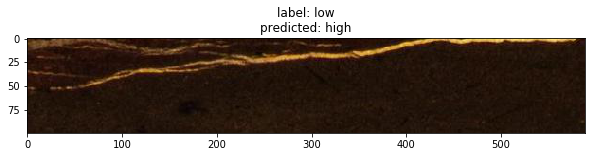

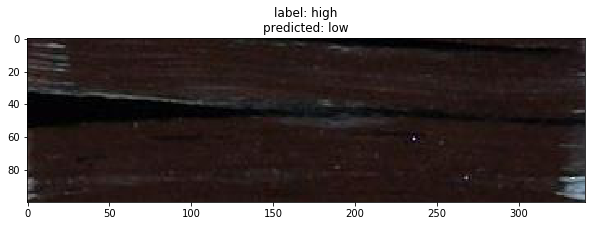

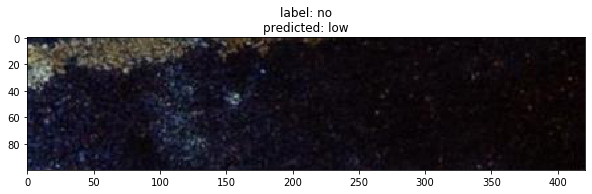

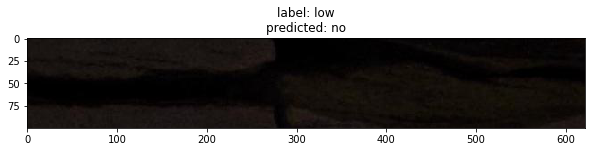

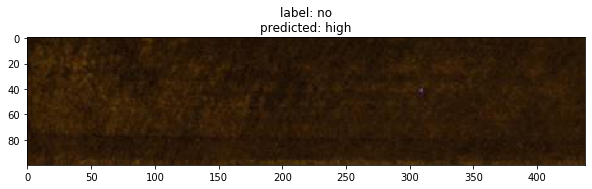

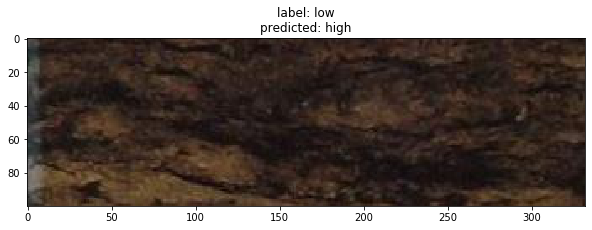

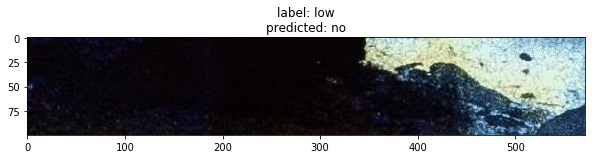

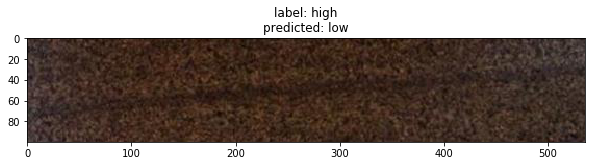

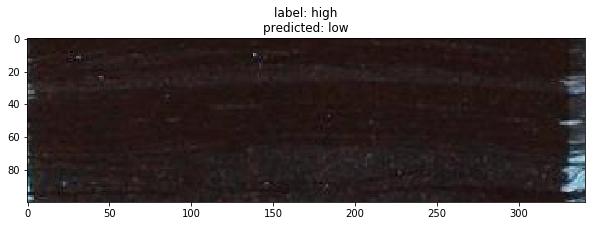

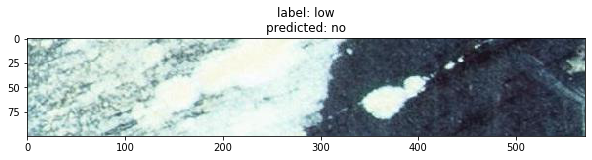

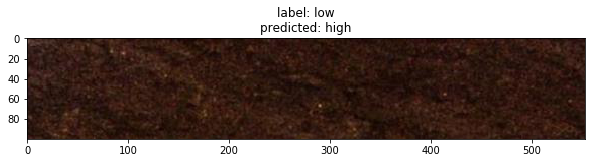

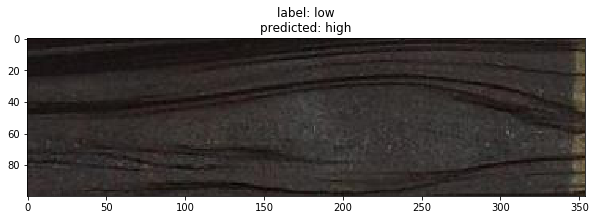

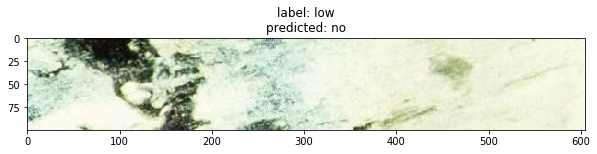

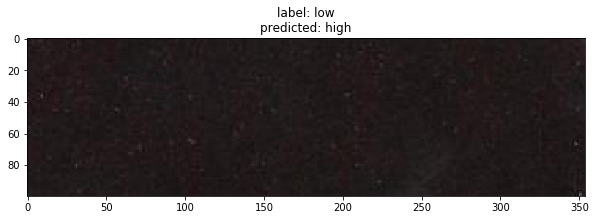

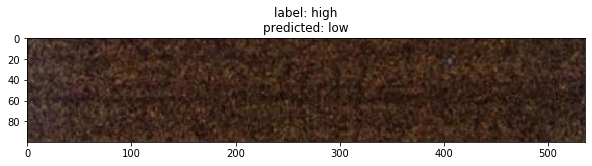

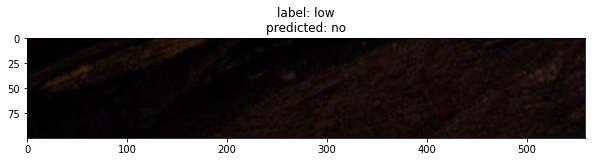

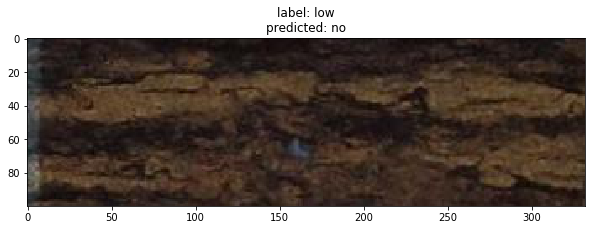

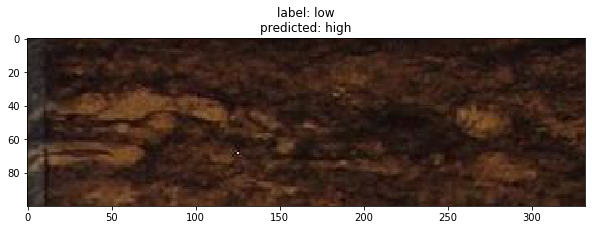

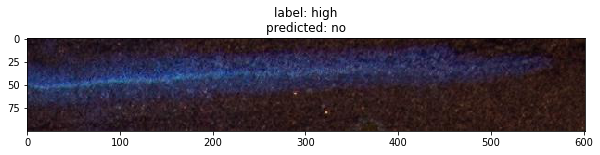

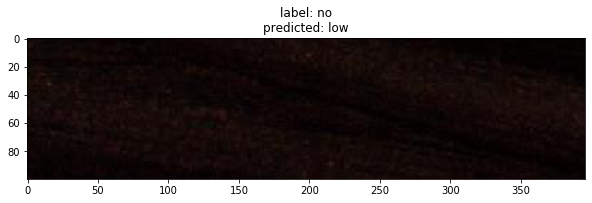

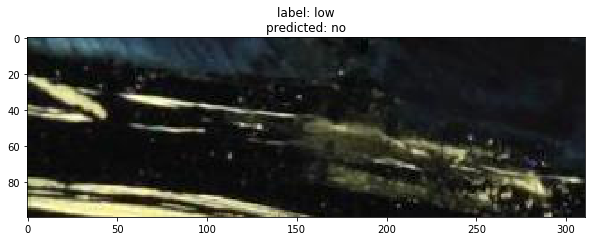

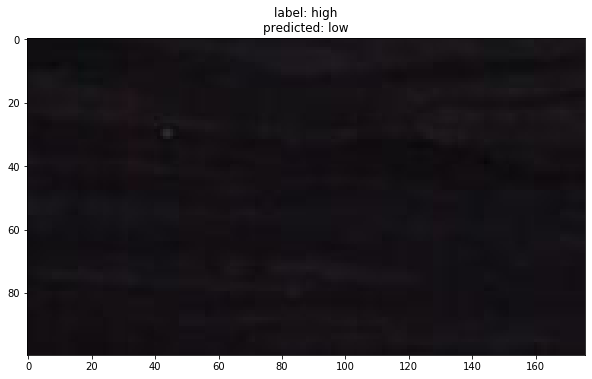

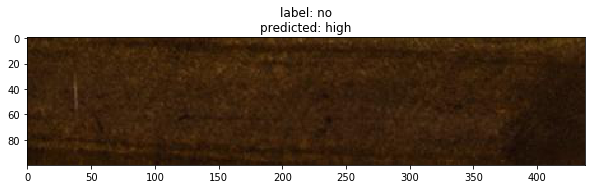

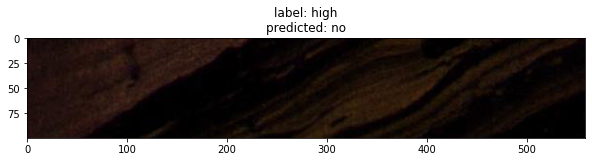

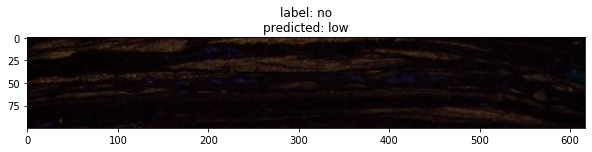

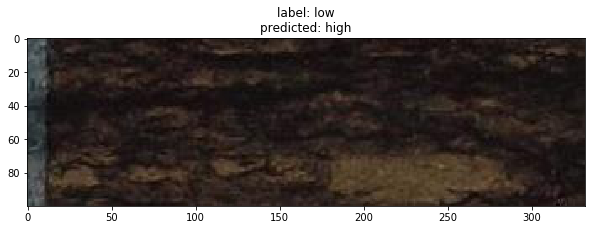

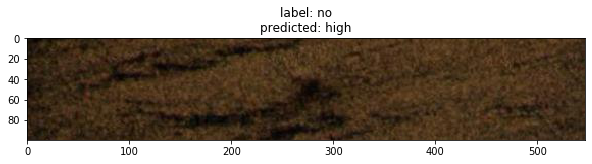

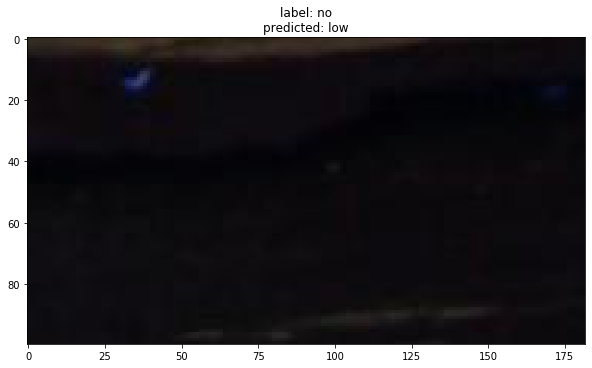

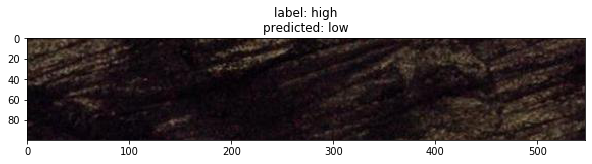

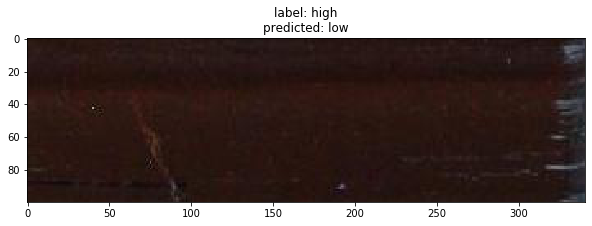

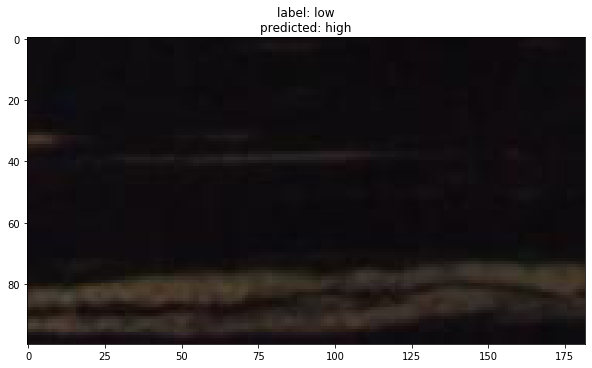

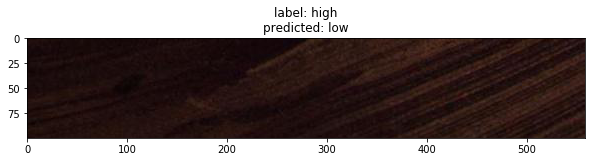

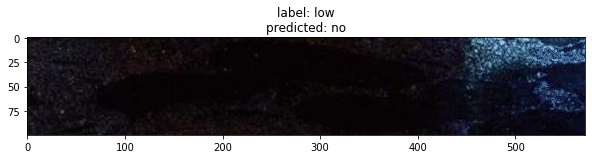

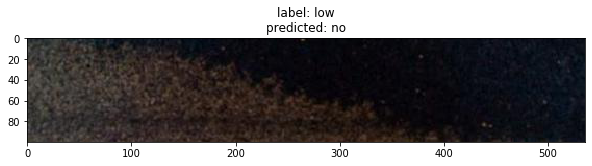

Accuracy of the model: 89 %
[0.909835176751247, 0.9793952180028129, 0.888157894736842]


In [13]:
ms = multi_score(rfc, X, y)
print(ms)